In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('oxygen_sensor_final_with_faults.csv')
df = pd.DataFrame(data)

In [3]:
df.head()

,OxygenSensorVoltage[Volts],EngineCoolantTemperature[°C],AirFuelRatio[AFR],ExhaustGasTemperature[°C],EngineRPM[Speed],FuelTrim[Percentage],ThrottlePosition[Percentage],IntakeAirTemperature[°C],ExhaustBackPressure[PSI],SensorAge[Years],OxygenSensorPerformance
0,0.133971,85.711229,14.876853,312.529070,3098.557366,1.651666,44.840702,45.977272,6.710284,4.380424,55.126267
1,0.879347,77.969518,14.749369,307.404173,3430.542973,1.463178,40.880080,14.482275,5.522438,6.669764,65.590163
2,0.436673,87.140711,14.678757,337.332712,2427.682826,0.469127,55.423466,26.044474,6.580602,3.376344,61.422792
3,0.644376,75.270197,14.688729,305.795052,3036.369347,0.189135,48.049772,28.508178,6.320000,11.333497,60.947541
4,0.176525,79.445058,14.626196,277.517622,3949.991651,-3.134807,32.939926,25.008879,8.927150,7.264019,52.440055


In [4]:
df.tail()

,OxygenSensorVoltage[Volts],EngineCoolantTemperature[°C],AirFuelRatio[AFR],ExhaustGasTemperature[°C],EngineRPM[Speed],FuelTrim[Percentage],ThrottlePosition[Percentage],IntakeAirTemperature[°C],ExhaustBackPressure[PSI],SensorAge[Years],OxygenSensorPerformance
219995,1.394655,114.012841,15.716131,432.212906,8069.934039,10.014998,139.385893,178.521858,20.255381,19.666125,17.753774
219996,1.021059,114.217006,15.423067,437.462624,8035.835237,12.897552,109.007101,167.390509,16.332833,19.719154,29.476310
219997,1.136655,104.586500,15.389176,438.170174,7762.041593,14.322598,126.512549,142.951976,20.763097,16.441528,17.779924
219998,1.199484,107.792086,15.439933,412.963225,7304.829672,10.238556,105.157214,181.517459,17.910364,19.898120,1.507044
219999,1.077511,108.825342,15.497009,494.728696,7018.654455,14.538397,125.165936,155.561695,18.607327,15.011701,11.566282


In [5]:
df.shape

(220000, 11)

In [6]:
df.isnull().sum()

OxygenSensorVoltage[Volts]      0
EngineCoolantTemperature[°C]    0
AirFuelRatio[AFR]               0
ExhaustGasTemperature[°C]       0
EngineRPM[Speed]                0
FuelTrim[Percentage]            0
ThrottlePosition[Percentage]    0
IntakeAirTemperature[°C]        0
ExhaustBackPressure[PSI]        0
SensorAge[Years]                0
OxygenSensorPerformance         0
dtype: int64

In [7]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [8]:
X = pd.DataFrame(X)

In [9]:
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
X = X.drop(columns=drop_cols)

In [10]:
print(X.columns)

Index(['OxygenSensorVoltage[Volts]', 'EngineCoolantTemperature[°C]',
       'AirFuelRatio[AFR]', 'ExhaustGasTemperature[°C]', 'EngineRPM[Speed]',
       'FuelTrim[Percentage]', 'ThrottlePosition[Percentage]',
       'IntakeAirTemperature[°C]', 'ExhaustBackPressure[PSI]',
       'SensorAge[Years]'],
      dtype='object')


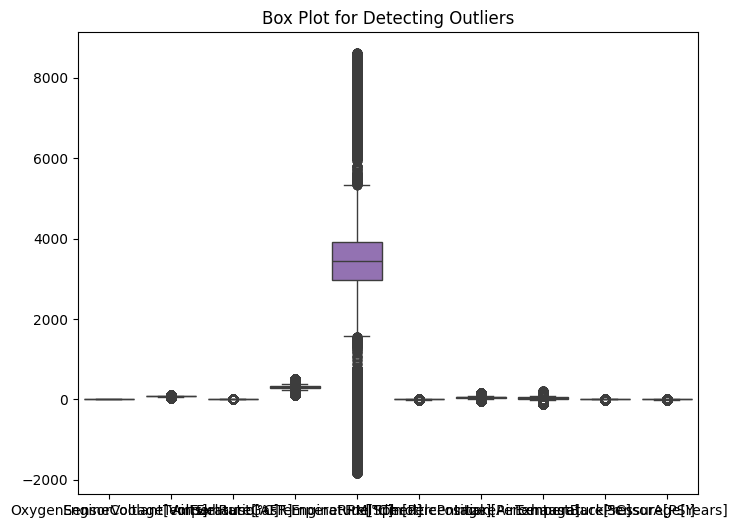

In [11]:
plt.figure(figsize=(8,6))
sns.boxplot(data=X)
plt.title('Box Plot for Detecting Outliers')
plt.show()

In [12]:
Q1 = np.percentile(X, 25, axis = 0)
Q3 = np.percentile(X, 75, axis = 0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = (X >= lower_bound) & (X <= upper_bound)
filtered_indices = np.all(mask, axis=1)

X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

print('Outliers removed. New Dataset shape: ', X_filtered.shape)

Outliers removed. New Dataset shape:  (196879, 10)


In [13]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtered)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_filtered, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = xgb_model.predict(X_test)

In [17]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error (MSE): ', mse)
print('Mean Absolute Error (MAE): ', mae)
print('R-Squared (R2): ', r2)

Mean Squared Error (MSE):  10.034440652940114
Mean Absolute Error (MAE):  2.524188737947607
R-Squared (R2):  0.880998244841071


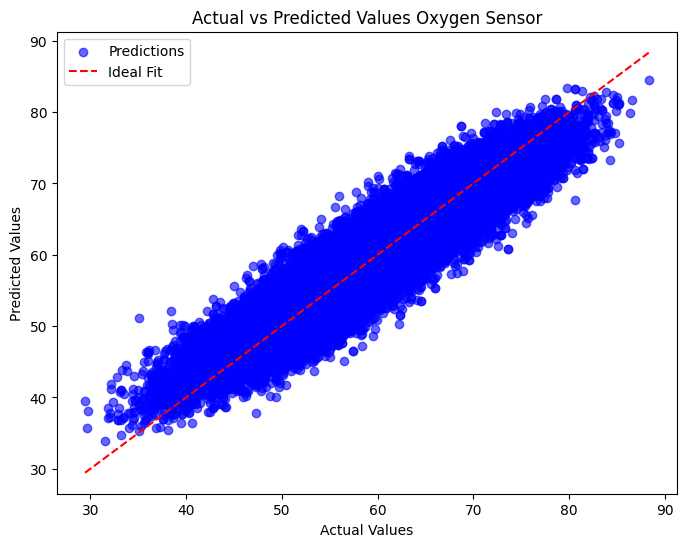

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color = 'blue', alpha = 0.6, label = 'Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', linestyle = '--', label = 'Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Oxygen Sensor')
plt.legend()
plt.show()

In [20]:
feature_columns = [
    'OxygenSensorVoltage[Volts]',
    'EngineCoolantTemperature[°C]',
    'AirFuelRatio[AFR]',
    'ExhaustGasTemperature[°C]',
    'EngineRPM[Speed]',
    'FuelTrim[Percentage]',
    'ThrottlePosition[Percentage]',
    'IntakeAirTemperature[°C]',
    'ExhaustBackPressure[PSI]'
]

target_variable = 'OxygenSensorPerformance'

correlation_matrix = df[feature_columns + [target_variable]].corr()

correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)
print(correlation_with_target)

OxygenSensorPerformance         1.000000
OxygenSensorVoltage[Volts]      0.363993
ExhaustGasTemperature[°C]       0.166124
FuelTrim[Percentage]            0.161080
ThrottlePosition[Percentage]    0.144709
IntakeAirTemperature[°C]        0.115904
EngineRPM[Speed]               -0.134902
AirFuelRatio[AFR]              -0.146735
EngineCoolantTemperature[°C]   -0.146900
ExhaustBackPressure[PSI]       -0.153292
Name: OxygenSensorPerformance, dtype: float64
